# ARK Holding Risk analysis
Taking the snapshot holding of ARK Innovation ETF (ARKK) on 2025-07-18

2025-07-21

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from utils.data.source import YahooFinanceDB
import seaborn as sns

#### Load ARK Innovation ETF holdings (with GICS meta-data manually added)

In [3]:
h_df = pd.read_csv('data/20250718_ARK_INNOVATION_ETF_ARKK_HOLDINGS.csv', index_col=3, parse_dates=True)
h_df = h_df.dropna(subset=['weight (%)'])

In [63]:
h_df.head(5)

,date,fund,company,cusip,shares,market value ($),weight (%),GICS Sector,GICS Industry Group,GICS Industry,GICS Sub-Industry,weight
ticker,,,,,,,,,,,,
TSLA,7/18/2025,ARKK,TESLA INC,88160R101,"2,213,566","$707,035,116.06",9.57%,Consumer Discretionary,Automobiles & Components,Automobiles,Automobile Manufacturers,0.097573
COIN,7/18/2025,ARKK,COINBASE GLOBAL INC -CLASS A,19260Q107,"1,596,082","$655,590,681.50",8.87%,Financials,Financial Services,Capital Markets,Financial Exchanges & Data,0.090436
RBLX,7/18/2025,ARKK,ROBLOX CORP -CLASS A,771049103,"4,156,071","$507,747,194.07",6.87%,Communication Services,Media & Entertainment,Entertainment,Interactive Home Entertainment,0.070045
ROKU,7/18/2025,ARKK,ROKU INC,77543R102,"5,442,551","$495,816,396.10",6.71%,Communication Services,Media & Entertainment,Entertainment,Movies & Entertainment,0.068414
CRCL,7/18/2025,ARKK,CIRCLE INTERNET GROUP INC,172573107,"1,719,822","$404,295,755.76",5.47%,Information Technology,Software & Services,IT Services,Internet Services & Infrastructure,0.055771


In [37]:
count_sector = len(h_df['GICS Sector'].unique())
sector_colour = {g: sns.color_palette("tab10", count_sector)[idx] 
                 for idx, g in  enumerate(h_df['GICS Sector'].unique())}

count_indu_group = len(h_df['GICS Industry Group'].unique())
indu_group_colour = {g: sns.color_palette("tab10", count_indu_group)[idx] 
                     for idx, g in  enumerate(h_df['GICS Industry Group'].unique())}

count_indu = len(h_df['GICS Industry'].unique())
indu_colour = {g: sns.color_palette("tab10", count_indu)[idx] for idx, g in  enumerate(h_df['GICS Industry'].unique())}

group_colour_map = {'GICS Sector': sector_colour,
                    'GICS Industry Group': indu_group_colour,
                    'GICS Industry': indu_colour}

def ticker_to_colour(ticker, group_by='GICS Sector'):
    """
    Returns the colour for a given ticker based on the group_by parameter.
    If group_by is None, returns black.
    :param ticker: str -  Ticker symbol of the stock
    :param group_by: str - Grouping criteria, e.g., 'GICS Sector', 'GICS Industry Group', 'GICS Industry'
    """
    if group_by is None:
        print('returning black since group_by == None')
        return (1, 1, 1)
    group = h_df.loc[ticker][group_by]
    if group_by == 'GICS Sector':
        return sector_colour[group]
    elif group_by == 'GICS Industry Group':
        return indu_group_colour[group]
    elif group_by == 'GICS Industry':
        print('warning - colours start to repeat after 10th')
        return indu_colour[group]
    else:
        raise ValueError(f'{group_by} not recognised - only supporting "GICS Sector", "GICS Industry Group" and "GICS Industry"')

In [7]:
START = pd.Timestamp('2020-01-01')
END = pd.Timestamp('2025-07-20')

#### Load asset prices from the internally onboarded Arctic DB data

In [8]:
yf_db = YahooFinanceDB()
# NASDAQ Composite Index
bmk_p_ts = yf_db.load_timeseries(ids='^IXIC',
                                fld='Close',
                                start=START,
                                end=END)
# ARKK ETF held names
prices_ts = yf_db.load_timeseries(ids=tuple(h_df.index),
                                  fld='Close',
                                  start=START,
                                  end=END)
prices_ts = prices_ts.ffill()
ret_ts = prices_ts.pct_change()
bmk_ret_ts = bmk_p_ts.pct_change()

#### Some names don't have good price history

In [9]:
pd.Series({col: prices_ts[col].first_valid_index() for col in prices_ts}).sort_values(ascending=False)

CRCL   2025-06-04
TEM    2024-06-14
GTLB   2021-10-14
HOOD   2021-07-29
RXRX   2021-04-16
COIN   2021-04-14
RBLX   2021-03-10
SOFI   2021-01-04
ACHR   2020-12-18
ABNB   2020-12-10
PLTR   2020-09-30
BEAM   2020-02-06
PINS   2020-01-02
TSLA   2020-01-02
TSM    2020-01-02
TTD    2020-01-02
TWST   2020-01-02
SHOP   2020-01-02
ROKU   2020-01-02
TXG    2020-01-02
VCYT   2020-01-02
TER    2020-01-02
NTRA   2020-01-02
PD     2020-01-02
PACB   2020-01-02
NVDA   2020-01-02
NTLA   2020-01-02
META   2020-01-02
KTOS   2020-01-02
IRDM   2020-01-02
ILMN   2020-01-02
GH     2020-01-02
DE     2020-01-02
CRSP   2020-01-02
CERS   2020-01-02
BWXT   2020-01-02
AMZN   2020-01-02
AMD    2020-01-02
XYZ    2020-01-02
dtype: datetime64[ns]

In [10]:
# only keep names for which we have prices
h_df = h_df.loc[h_df.index.isin(prices_ts.columns)]
h_df['weight'] = h_df['weight (%)'].str.rstrip('%').astype(float) / 100.0
h_df['weight'] = h_df['weight'] / h_df['weight'].sum()

C:\Users\kench\AppData\Local\Temp/ipykernel_8260/2783475680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df['weight'] = h_df['weight (%)'].str.rstrip('%').astype(float) / 100.0
C:\Users\kench\AppData\Local\Temp/ipykernel_8260/2783475680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df['weight'] = h_df['weight'] / h_df['weight'].sum()


In [11]:
rel_ts = ret_ts.sub(bmk_ret_ts.iloc[:,0], axis=0)

In [12]:
ret_ts.shape

(1393, 39)

In [13]:
window = 252
# relative (vs NDX) daily return time series
rel_ts = ret_ts.sub(bmk_ret_ts.iloc[:,0], axis=0)
rel_ts_subset = rel_ts.iloc[-window:].dropna(axis=1, how='any')
corr_start, corr_end = rel_ts.index[0].strftime('%Y-%m-%d'), rel_ts.index[-1].strftime('%Y-%m-%d')

In [14]:
def correlation_to_distance(corr_matrix):
    return np.sqrt(2 * (1 - corr_matrix))

In [15]:
rho_mat = rel_ts_subset.corr()
dist_mat = correlation_to_distance(rho_mat)

### Performing hierarchical clustering on the distance matrix

C:\Users\kench\AppData\Local\Temp/ipykernel_8260/2506044276.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_data = linkage(dist_mat.values, method=link_method)


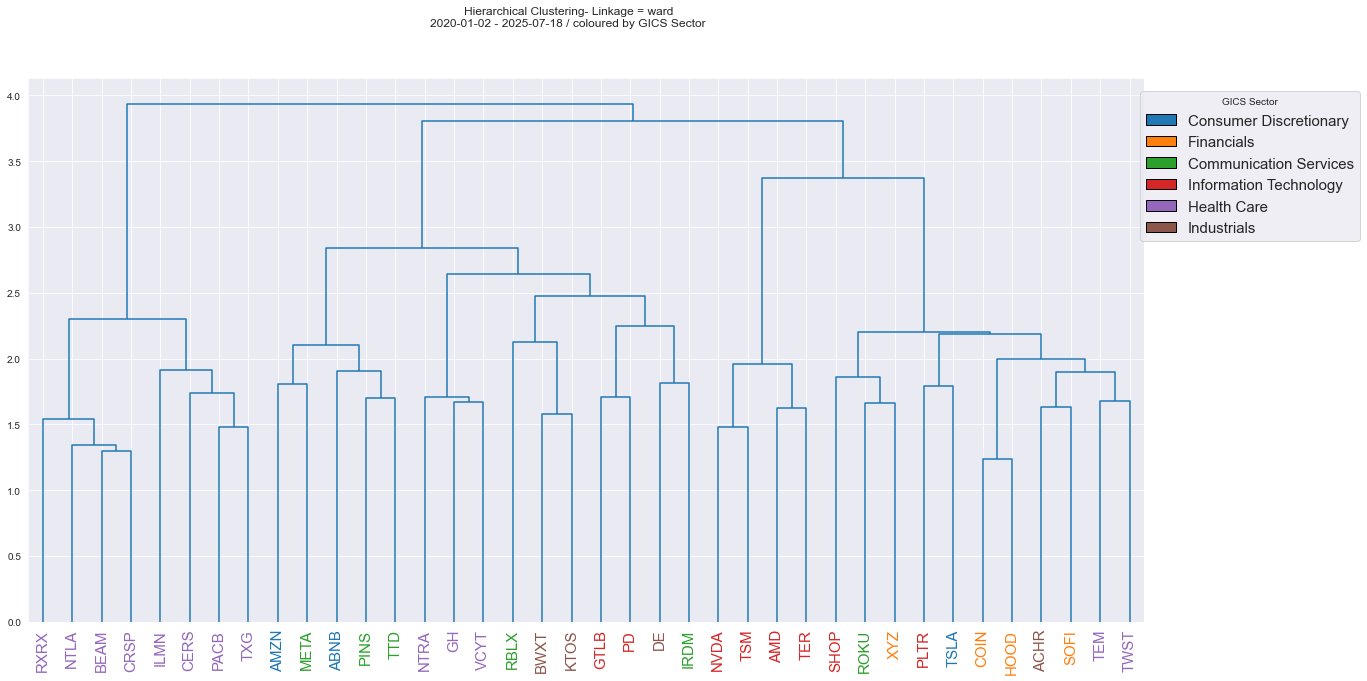

In [73]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(20, 10))
link_method = 'ward'
colour_by = 'GICS Sector'
#colour_by= 'GICS Industry Group'

linkage_data = linkage(dist_mat.values, method=link_method)
dendrogram(linkage_data, labels=dist_mat.index, leaf_rotation=90, leaf_font_size=15, color_threshold=0)

x_labels = plt.gca().get_xmajorticklabels()
for lbl in x_labels:
    lbl.set_color(ticker_to_colour(lbl.get_text(), group_by=colour_by))
    
plt.suptitle(f'Hierarchical Clustering- Linkage = {link_method}\n'
             f'{corr_start} - {corr_end} / coloured by {colour_by}')

# adding GICS colour coding as legends
custom_legend = [Patch(facecolor=_c, edgecolor='black', label=_g) for _g, _c in group_colour_map[colour_by].items()]
plt.legend(handles=custom_legend, title=colour_by, loc='upper right',  bbox_to_anchor=(1.2, 0.99), fontsize=15)
plt.show()

### Using tSNE to project the distance matrix into 2D space

In [18]:
from sklearn.manifold import TSNE
TSNE_PERP = 10
# Using TSNE to project a set of points based on a precomputed distance matrix
tsne_projection = TSNE(n_components=2, perplexity=TSNE_PERP, metric="precomputed", random_state=1).fit_transform(dist_mat.values)

C:\ProgramData\anaconda3\envs\dev\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


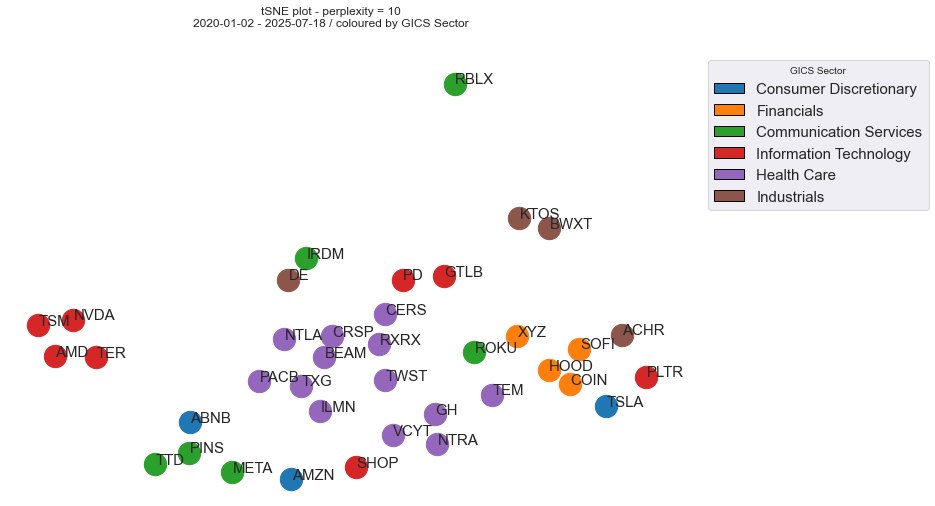

In [62]:
ax_tsne = plt.figure(figsize=(12, 8))
colour_by = 'GICS Sector'
#colour_by= 'GICS Industry Group'

for i, ticker in enumerate(dist_mat.columns):
    x, y = tsne_projection[i][0], tsne_projection[i][1]
    plt.scatter(x, y, 
                color=ticker_to_colour(ticker, group_by=colour_by),
                s=500)
    plt.text(x + 0.3,  y + 0.3, ticker, fontsize=15)
    plt.axis("off")
plt.suptitle(f'tSNE plot - perplexity = {TSNE_PERP}\n'
             f'{corr_start} - {corr_end} / coloured by {colour_by}')

# adding GICS colour coding as legends
custom_legend = [Patch(facecolor=_c, edgecolor='black', label=_g) for _g, _c in group_colour_map[colour_by].items()]
ax_tsne.legend(handles=custom_legend, title=colour_by, loc='upper right',  bbox_to_anchor=(1.2, 0.9), fontsize=15)
plt.show()